In [1]:
import pyccl as ccl
import levinpower
import numpy as np
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline


# Cosmology
cosmo = ccl.Cosmology(Omega_c=0.25, Omega_b=0.05, h=0.7, sigma8=0.8, n_s=0.965, transfer_function='eisenstein_hu')


In [15]:
z = np.linspace(0.1, 1, 1000)
nz = np.exp(-0.5*((z-0.5)/.002)**20)
b1 = np.ones_like(z)
tracers = {}
tracers['g']  = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z, nz), bias=(z, b1))
ell = np.unique((np.geomspace(2, 10000)).astype(int))




0.9999999999999999


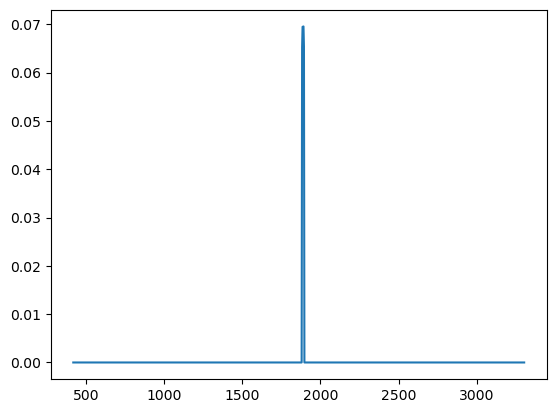

In [16]:

chi = ccl.comoving_radial_distance(cosmo,1/(1+z))
kmin, kmax, nk = 1e-4, 1e1, 500
k = np.geomspace((kmin), (kmax), nk) # Wavenumber
pk_nl = []
for zet in z:
    pk_nl.append(ccl.nonlin_matter_power(cosmo, k, 1/(1+zet)))
pk_nl = np.array(pk_nl)


spl = UnivariateSpline(chi, z, k=2, s=0)
dzdchi = spl.derivative()(chi)
norm = 1/np.trapz(nz*dzdchi,chi)
nofchi = dzdchi*nz*norm
idx_non_zero = np.where(nofchi >0)[0]

plt.plot(chi,nofchi)

print(np.trapz(nofchi,chi))

mean_chi = np.argmin(np.abs(chi - np.trapz(nz*dzdchi*norm*chi,chi)))


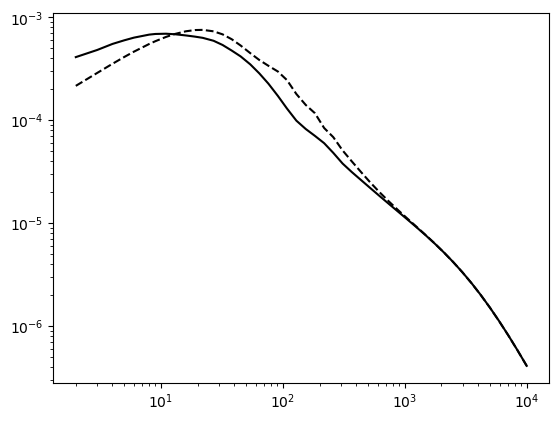

In [17]:
cls = ccl.angular_cl(cosmo, tracers['g'], tracers['g'], ell, l_limber = 10009,limber_max_error=0.0001) 
cls1 = ccl.angular_cl(cosmo, tracers['g'], tracers['g'], ell, l_limber = 1,limber_max_error=0.0001)

plt.loglog(ell, cls, 'k-')
plt.loglog(ell, cls1, 'k--')

In [25]:
integral_type = 2
N_thread = 8 # Number of threads used for hyperthreading
logx = True # Tells the code to create a logarithmic spline in x for f(x)
logy = True # Tells the code to create a logarithmic spline in y for y = f(x)
n_sub = 16 #number of collocation points in each bisection
n_bisec_max = 32 #maximum number of bisections used
rel_acc = 1e-4 #relative accuracy target
boost_bessel = True #should the bessel functions be calculated with boost instead of GSL, higher accuracy at high Bessel orders
verbose = False #should the code talk to you?

lower_limit = k[0]*np.ones_like(ell)
upper_limit = k[-1]*np.ones_like(ell)

integrand = (pk_nl[mean_chi,:]*k**2)[:,None]

nofchi = dzdchi*nz*norm

result_levin = np.zeros((len(idx_non_zero), len(idx_non_zero), len(ell)))
for i_chi, val_i_chi in enumerate(chi[idx_non_zero]):
    for j_chi, val_j_chi in enumerate(chi[idx_non_zero]):
        spline = UnivariateSpline(k, pk_nl[idx_non_zero[i_chi],:], k= 3, s = 0)
        power = spline(k)**.5
        spline = UnivariateSpline(k, pk_nl[idx_non_zero[j_chi],:], k= 3, s = 0)
        power *= spline(k)**.5
        integrand = power*k**2
        if i_chi <= j_chi:
            lp = levinpower.levinpower(integral_type, k, integrand[:,None], logx, logy, N_thread)
            lp.set_levin(n_sub, n_bisec_max, rel_acc, boost_bessel, verbose)
            result_levin[i_chi,j_chi,:] = (np.array(lp.levin_integrate_bessel_double(lower_limit, upper_limit, val_j_chi*np.ones_like(ell),val_i_chi*np.ones_like(ell),ell.astype(int),ell.astype(int), False))[:,0])
           



0
1
2
3
4
5
6


(7, 7, 47)
[[[ 4.55681280e-04  4.55425772e-04  4.56732050e-04 ...  2.79338902e-05
    2.19316094e-05  1.66935199e-05]
  [ 3.07444733e-04  3.08816354e-04  3.10208010e-04 ...  2.30937642e-07
    2.58915260e-07 -5.30339245e-08]
  [ 2.64193619e-04  2.65618216e-04  2.66964621e-04 ... -1.32498847e-07
    8.08048100e-08 -3.93538353e-08]
  ...
  [ 2.04067946e-04  2.05419331e-04  2.06840715e-04 ...  3.80108919e-08
   -6.44301224e-08 -3.42462800e-08]
  [ 1.80276681e-04  1.81663133e-04  1.82980760e-04 ... -5.52847083e-08
    2.95806976e-09 -3.27193564e-08]
  [ 1.59359828e-04  1.60773206e-04  1.62073067e-04 ...  2.85747329e-08
    4.41604758e-08 -3.12988395e-08]]

 [[ 3.07444733e-04  3.08816354e-04  3.10208010e-04 ...  2.30937642e-07
    2.58915260e-07 -5.30339245e-08]
  [ 4.53679160e-04  4.53506663e-04  4.54837610e-04 ...  2.78698523e-05
    2.18866904e-05  1.66652422e-05]
  [ 3.06225387e-04  3.07637681e-04  3.09027548e-04 ...  2.30743999e-07
    2.57891540e-07 -5.22464250e-08]
  ...
  [ 2.307584

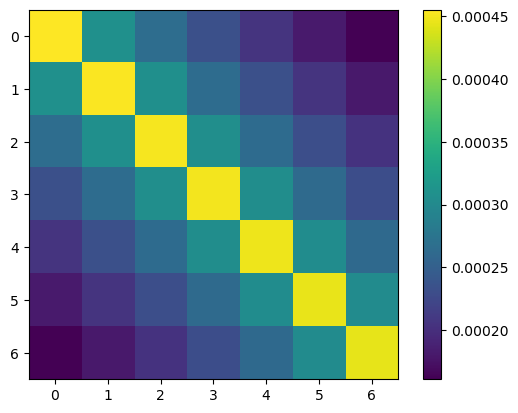

In [30]:
print(result_levin.shape)

for i in range(len(idx_non_zero)):
    for j in range(i,len(idx_non_zero)):
        result_levin[j,i,:] = result_levin[i,j,:]

result_levin_first = np.trapz(result_levin*(nofchi[idx_non_zero])[None, :, None] , chi[idx_non_zero],axis = 1)
result_levin_second = np.trapz((nofchi[idx_non_zero])[:, None]*result_levin_first , chi[idx_non_zero],axis = 0)


In [39]:
from scipy.special import spherical_jn



N_int = int(1e4)
k_int = np.geomspace(k[0], 1e1, N_int)
bessel = []
spline = UnivariateSpline(k, pk_nl[mean_chi,:], k= 3, s = 0) # assume power spectrum is constant over bin
for i_chi, val_chi in enumerate(chi[idx_non_zero]):
    bessel.append([])
    power = spline(k_int)#ccl.nonlin_matter_power(cosmo,k_int,1./(1+z[idx_non_zero[i_chi]]))#spline(k_int)**.5
    for ell_i, ell_val in enumerate(ell):
        bessel[i_chi].append(spherical_jn(ell_val,val_chi*k_int)*power**.5)

bessel = np.array(bessel)
integral_1 = np.trapz(nofchi[idx_non_zero,None, None]*bessel,chi[idx_non_zero], axis=0)
result = 2/np.pi*np.trapz((integral_1**2*k_int**2),k_int, axis = -1)

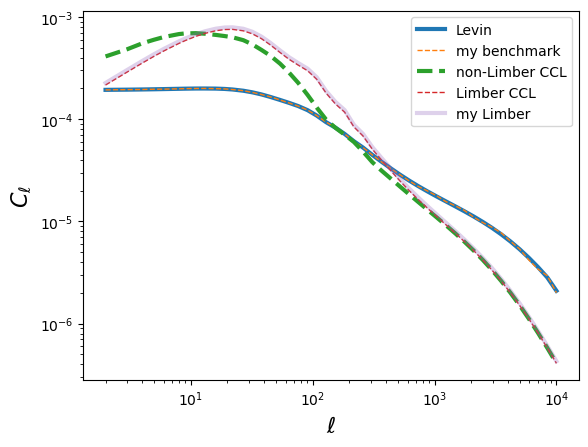

In [40]:


my_limber = np.trapz((nofchi**2)[None,:]/chi**2*spline((ell+.5)/chi[mean_chi])[:,None],chi)

#plt.loglog(ell,result_levin, ls = "-")
plt.loglog(ell,result_levin_second*2/np.pi, ls = "-", label = r"Levin", lw = 3)
plt.loglog(ell,result, ls = "--", label = r"my benchmark", lw= 1)

plt.loglog(ell,cls, ls = "--", label = r"non-Limber CCL", lw = 3)
plt.loglog(ell,cls1, ls = "--", label = r"Limber CCL", lw = 1)
plt.loglog(ell,my_limber, ls = "-",  label = r"my Limber", lw = 3, alpha = .3)
plt.xlabel(r"$\ell$", fontsize = 16)
plt.ylabel(r"$C_\ell$", fontsize = 16)
plt.legend()
